In [2]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is enabled: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead")

GPU is enabled: Tesla T4


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch torchvision pillow matplotlib

In [4]:
# First uninstall existing packages
#!pip uninstall torch torchvision -y

# Then reinstall with --no-cache-dir flag
!pip install torch torchvision pillow matplotlib --no-cache-dir

In [5]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt

In [6]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
#Our Custom Dataset
class WasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['O', 'R']  # O=Organic, R=Recyclable
        self.image_paths = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append((os.path.join(class_dir, img_name), i))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

In [8]:
#unzip the dataset
!unzip -q "/content/drive/MyDrive/waste-classification-data.zip" -d "/content/dataset"

replace /content/dataset/DATASET/TEST/O/O_12568.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/DATASET/TEST/O/O_12569.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
train_dataset = WasteDataset('/content/dataset/DATASET/TRAIN', transform=transform)
test_dataset = WasteDataset('/content/dataset/DATASET/TEST', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1),
    nn.Sigmoid()
).to(device)  # Move classifier to GPU immediately

model = model.to(device)  # Move entire model to GPU
print(f"Model moved to: {next(model.parameters()).device}")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)


Model moved to: cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 0: Loss 0.7169
Epoch 1, Batch 50: Loss 0.2735
Epoch 1, Batch 100: Loss 0.2448
Epoch 1, Batch 150: Loss 0.3403
Epoch 1, Batch 200: Loss 0.2577
Epoch 1, Batch 250: Loss 0.1613
Epoch 1, Batch 300: Loss 0.2181
Epoch 1, Batch 350: Loss 0.2903
Epoch 1, Batch 400: Loss 0.2573
Epoch 1, Batch 450: Loss 0.2069
Epoch 1, Batch 500: Loss 0.1398
Epoch 1, Batch 550: Loss 0.1445
Epoch 1, Batch 600: Loss 0.1894
Epoch 1, Batch 650: Loss 0.2521
Epoch 1, Batch 700: Loss 0.1970
Epoch 1/10, Avg Loss: 0.2755
Epoch 2, Batch 0: Loss 0.4372
Epoch 2, Batch 50: Loss 0.1752
Epoch 2, Batch 100: Loss 0.4401
Epoch 2, Batch 150: Loss 0.5186
Epoch 2, Batch 200: Loss 0.2832
Epoch 2, Batch 250: Loss 0.1692
Epoch 2, Batch 300: Loss 0.3205
Epoch 2, Batch 350: Loss 0.3231
Epoch 2, Batch 400: Loss 0.2066
Epoch 2, Batch 450: Loss 0.2284
Epoch 2, Batch 500: Loss 0.1328
Epoch 2, Batch 550: Loss 0.1719
Epoch 2, Batch 600: Loss 0.3083
Epoch 2, Batch 650: Loss 0.2494
Epoch 2, Batch 700: Loss 0.1797
Epoch 2/10, Avg L

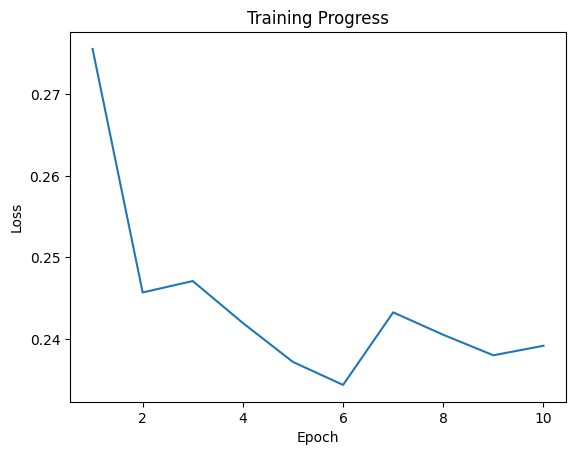

In [11]:
# Enhanced training loop with GPU and progress tracking
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Move data to GPU in batches
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print every 50 batches
        if batch_idx % 50 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}: Loss {loss.item():.4f}')

    epoch_loss = running_loss/len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {epoch_loss:.4f}')

# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/waste_model_gpu.pth')
print("Model saved with GPU-trained weights")

# Plot training progress
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

In [12]:
#accuracy evaluation
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

train_acc = calculate_accuracy(train_loader)
test_acc = calculate_accuracy(test_loader)

print(f'Training Accuracy: {train_acc:.2f}%')
print(f'Test Accuracy: {test_acc:.2f}%')

Training Accuracy: 92.86%
Test Accuracy: 91.96%


In [13]:
#Quick restart- in order to avoid training the model again
# Mount Drive & check GPU
from google.colab import drive
drive.mount('/content/drive')

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Cell 2: Load the saved model
from torchvision import models
import torch.nn as nn

model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1),
    nn.Sigmoid()
).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/waste_model_gpu.pth'))
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
#Verify loading
print("Model loaded successfully!")
print(f"Device: {next(model.parameters()).device}")

Model loaded successfully!
Device: cuda:0


In [16]:
# Save to Google Drive (permanent storage)
torch.save(model.state_dict(), '/content/drive/MyDrive/waste_model_mobilenet.pth')
print("MobileNetV2 model saved to Google Drive")

MobileNetV2 model saved to Google Drive
